In [1]:
import pyreadr 
import pandas as pd
import numpy as np
from datetime import datetime as dt
import seaborn as sns
import os


import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier

import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(42)

In [2]:
data_ml = pyreadr.read_r(os.path.join(os.path.expanduser('~'),'Downloads','data_ml.RData'))["data_ml"]
data_ml.date = pd.to_datetime(data_ml.date)
data_ml = data_ml.loc[(data_ml['date'] > "1999-12-31") & (data_ml['date'] < "2019-01-01")]
data_ml.sort_values(by = ['stock_id','date'], inplace = True)
data_ml['R1M_Usd_C'] = data_ml.R1M_Usd >  data_ml.groupby('date').R1M_Usd.transform('median')


features = list(data_ml.columns[2:95])
features_short = ["Div_Yld", "Eps", "Mkt_Cap_12M_Usd", "Mom_11M_Usd", 
                    "Ocf", "Pb", "Vol1Y_Usd"]
stock_ids = data_ml.stock_id.unique()                                                                                           
stock_days = data_ml.stock_id.value_counts().sort_index()                                           
stock_ids_short = stock_ids[stock_days.values == max(stock_days.values)]                            
returns_short = data_ml[data_ml['stock_id'].isin(stock_ids_short)][['date','stock_id','R1M_Usd']]
returns = returns_short.pivot_table(index='date',columns='stock_id',values='R1M_Usd')
separation_date = dt.strptime("2014-01-15","%Y-%m-%d")
training_sample = data_ml[data_ml.date < separation_date]
testing_sample = data_ml[data_ml.date  >= separation_date]

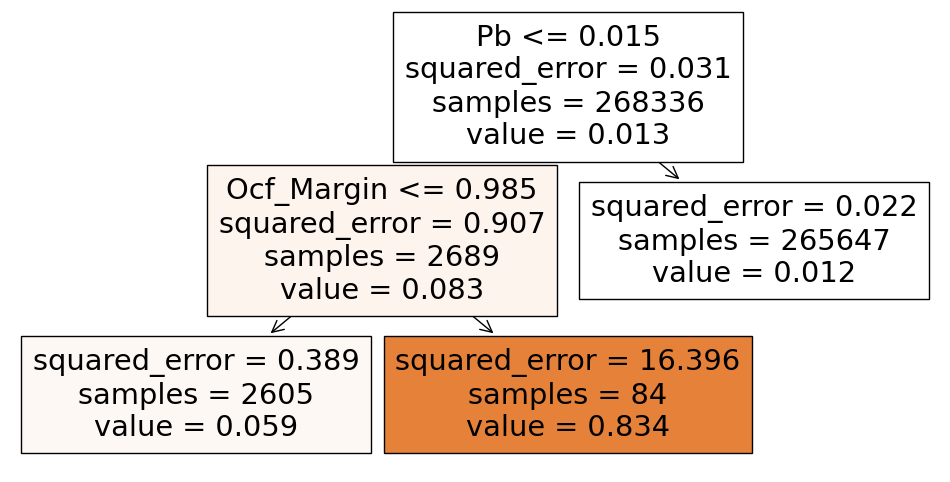

In [3]:

model_tree = DecisionTreeRegressor(min_samples_leaf = 35, #The minimum number of samples required to be at a leaf node.change variable 3500 to 35 
                                min_samples_split = 800,#The minimum number of samples required to split an internal node. change variable 8000 to 800 
                                ccp_alpha = 0.0001,     #Complexity parameter used for Minimal Cost-Complexity Pruning. smaller cp = more leaves
                                max_depth = 3)          #The maximum depth of the tree
fit_tree = model_tree.fit(data_ml[features], data_ml['R1M_Usd'])

plt.figure(figsize=(12, 6))
plot_tree(fit_tree, feature_names=features,class_names=data_ml['R1M_Usd'], filled=True)
plt.show()


In [4]:
fit_tree.predict(data_ml[features][:5])


array([0.0120192, 0.0120192, 0.0120192, 0.0120192, 0.0120192])

C:\Users\SE24171\AppData\Local\Temp\ipykernel_23228\2949844853.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=data_ml,x="Mkt_Cap_3M_Usd", y="R1M_Usd", ci=None)
C:\Users\SE24171\AppData\Local\Temp\ipykernel_23228\2949844853.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=data_ml,x="Pb", y="R1M_Usd", ci=None)
C:\Users\SE24171\AppData\Local\Temp\ipykernel_23228\2949844853.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=data_ml,x="Advt_3M_Usd", y="R1M_Usd", ci=None)


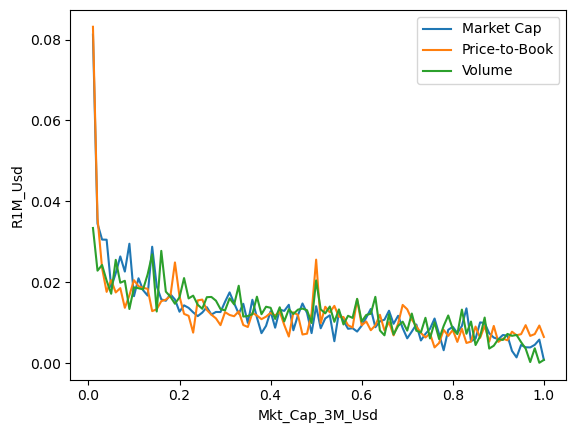

In [5]:
sns.lineplot(data=data_ml,x="Mkt_Cap_3M_Usd", y="R1M_Usd", ci=None)
sns.lineplot(data=data_ml,x="Pb", y="R1M_Usd", ci=None)
sns.lineplot(data=data_ml,x="Advt_3M_Usd", y="R1M_Usd", ci=None)
plt.legend(labels=['Market Cap', 'Price-to-Book','Volume'])

In [6]:
model_tree2 = DecisionTreeRegressor(
                                min_samples_leaf = 15,   # change variable 1500 to 15
                                min_samples_split = 400, #change variable 4000 to 400
                                ccp_alpha = 0.0001,      #Complexity par used for Min Cost-Complexity Pruning. smaller cp = more leaves
                                max_depth = 5,           
                                )          
fit_tree2 = model_tree2.fit(training_sample[features], training_sample.R1M_Usd)

In [7]:
print("MSE:", mean_squared_error(fit_tree2.predict(testing_sample[features]), testing_sample.R1M_Usd) )
print("Hit ratio:", (fit_tree2.predict(testing_sample[features]) * testing_sample.R1M_Usd > 0 ).mean() )


MSE: 0.03699695809185004
Hit ratio: 0.5460346399270738


In [8]:
model_RF = RandomForestRegressor( 
                            #    max_samples = 10000,   #If bootstrap is True, num of samples to draw from X to train each base estimator.
                                bootstrap = False,      # If False, the whole dataset is used to build each tree.
                                min_samples_leaf= 250,  # min num of samples required to be at a leaf node. 
                                n_estimators = 40,      # num of trees in the forest.
                                max_features = 30       # num of features to consider when looking for the best split:
                                )     
                
fit_RF = model_RF.fit(training_sample[features], training_sample.R1M_Usd)
fit_RF.predict(testing_sample[features][:5])

array([-0.00092054,  0.00339376, -0.0070559 , -0.00601938,  0.00139753])

In [9]:
print("MSE:", mean_squared_error(fit_RF.predict(testing_sample[features]), testing_sample.R1M_Usd) )
print("Hit ratio:", (fit_RF.predict(testing_sample[features]) * testing_sample.R1M_Usd > 0 ).mean() )

MSE: 0.03687100036668765
Hit ratio: 0.5400951458523245


In [10]:
model_RF_C = RandomForestClassifier( 
                            #    max_samples = 10000,   #If bootstrap is True, num of samples to draw from X to train each base estimator.
                                bootstrap = False,      # If False, the whole dataset is used to build each tree.
                                min_samples_leaf= 250,  # min num of samples required to be at a leaf node. 
                                n_estimators = 40,      # num of trees in the forest.
                                max_features = 30       # num of features to consider when looking for the best split:
                                )
fit_RF_C = model_RF_C.fit(training_sample[features], training_sample.R1M_Usd_C)

In [11]:
print("Hit ratio:", (fit_RF_C.predict(testing_sample[features]) == testing_sample.R1M_Usd_C ).mean() )


Hit ratio: 0.5035038742023701


In [12]:
subsample = np.arange(len(training_sample) // 4 ) * 4
training_sub_sample= training_sample.iloc[subsample]
fit_adaboost_C = AdaBoostClassifier(n_estimators = 3) # max num of estimators at which boosting is terminated.
fit_adaboost_C.fit(training_sub_sample[features], training_sub_sample.R1M_Usd_C)

c:\Users\SE24171\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(n_estimators=3)

In [13]:
print("Hit ratio:", (fit_adaboost_C.predict(testing_sample[features]) == testing_sample.R1M_Usd_C ).mean() )


Hit ratio: 0.49951572470373745


In [14]:
top20 = training_sample['R1M_Usd'].quantile(0.8) 
bottom20= training_sample['R1M_Usd'].quantile(0.2)

train_features = training_sample[(training_sample['R1M_Usd'] > top20) | (training_sample['R1M_Usd'] < bottom20) ]
train_features_xgb = train_features[features_short]
train_label_xgb = train_features['R1M_Usd']

In [15]:
mono_const = np.zeros(len(features_short))
mono_const += (np.array(features_short)=='Mkt_Cap_12M_Usd' ) * (-1)
mono_const += (np.array(features_short)=='Pb' ) * (-1)
mono_const += (np.array(features_short)=='Mom_11M_Usd' ) * 1

In [16]:
model_xgb = xgb.XGBRegressor(     
              learning_rate  = 0.3,                                                                      
              objective = "reg:squarederror",                                              
              max_depth = 4,                                                             
              subsample=0.6,             
              colsample_bytree=0.7,      
              reg_lambda = 1,                  #L2 regularization on weights
              gamma = 0.1,                     #Min loss reduction required to make a further partition on a leaf node of the tree.
              n_estimators = 30,               #Num of trees in random forest to fit.
              monotone_constraints = '('+','.join(str(int(x)) for x in mono_const) + ')',  
              rate_drop=0.1,
              verbosity  = 0                                                              
            )       
fit_xgb = model_xgb.fit(train_features_xgb,train_label_xgb )    

In [17]:
xgb_test = testing_sample[features_short]
print("MSE:", mean_squared_error(fit_xgb.predict(xgb_test), testing_sample.R1M_Usd) )
print("Hit ratio:", (fit_xgb.predict(xgb_test) * testing_sample.R1M_Usd > 0 ).mean() )

MSE: 0.03836882497171777
Hit ratio: 0.4996724020054695


In [18]:
train_label_C = train_features['R1M_Usd_C']
model_xgb_C = xgb.XGBClassifier(     
              learning_rate  = 0.8,                     
              objective = "multi:softmax",               
              num_class = 2,                            
              max_depth = 4,                                           
              n_estimators = 10,                         
              verbosity  = 0                            
            )
fit_xgb_C = model_xgb_C.fit(train_features_xgb,train_label_C )

In [19]:
print("Hit ratio:", (fit_xgb_C.predict(testing_sample[features_short]) == testing_sample.R1M_Usd_C ).mean() )


Hit ratio: 0.4956130355515041
